In [1]:
import subprocess
import os

import matplotlib.pyplot as plt
import logging

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.INFO)

from generation import generate
from parseRePEAT import *

In [2]:
previous_beta = 0

def plot_atf(segments, label, color, eatfs, fig, axs):
    global previous_beta
    line = None
    for (x0, x1, y0, y1) in segments:
        if x0 == "-inf" and x1 != "inf" and y1 != "inf":
            axs[0].hlines(float(y1), 0, float(x1), colors=color)
        line, = axs[0].plot([float(x0), float(x1)], [float(y0), float(y1)], color=color)
    line.set_label(label) if line is not None else None

    for (zeta, alpha, beta, delta, gammas) in list(eatfs.values())[0]:
        min_gammas = [float(gamma[0]) for gamma in gammas]
        min_gamma = sum(min_gammas)

        length_edge = max(0.0, float(beta)-float(alpha))
        max_gammas = [float(gamma[1]) for gamma in gammas]
        max_gamma = sum(max_gammas)
        alpha = float(alpha)
        beta = float(beta)
        gamma_diff = max_gamma - min_gamma
        if length_edge > gamma_diff:
            axs[1].plot([alpha, beta - gamma_diff], [min_gamma, min_gamma], color=color)
            alpha = beta - gamma_diff

        if alpha <= beta:
            axs[1].plot([previous_beta, alpha], [min_gamma, min_gamma], color=color)
            axs[1].plot([alpha, beta], [min_gamma, max_gamma], color=color)
        else:
            axs[1].plot([previous_beta, beta - (gamma_diff)], [min_gamma, min_gamma], color=color)
            axs[1].plot([beta - (gamma_diff), beta], [min_gamma, max_gamma], color=color)
        # axs[1].plot([float(alpha), float(beta)], [min_gammas, max_gammas], color=color)
        previous_beta = beta

        pybooklogger.info(f"{alpha}, {beta}, {gammas}, {min_gammas} - {max_gammas}")

In [3]:
class Agent:
    def __init__(self, id, origin, destination, velocity, start_time):
        self.id = id
        self.origin = origin
        self.destination = destination
        self.velocity = velocity
        self.start_time = start_time

class Layout:
    def __init__(self, layout):
        self.g, self.g_block, self.g_duration = generate.time_graph_creation(layout)

    def station_to_block(self, station, direction=0):
        if station in self.g_block.stations:
            if direction == "A":
                direction = 0
            if direction == "B":
                direction = 1
            return self.g_block.stations[station][direction]
        pybooklogger.error(f"Station {station} not found")
        return station

class Scenario:
    def __init__(self, l: Layout, scen_file, agent_id, max_buffer_time, use_recovery_time):
        self.l = l
        self.block_intervals, self.moves_per_agent, self.unsafe_computation_time, self.block_routes, self.buffer_times, self.recovery_times, self.flexibility_duration = generate.time_scenario_creation(scen_file, self.l.g, self.l.g_block, agent_id, max_buffer_time, use_recovery_time)

    def plot(self, agent_to_plot_route_of):
        generate.plot_route(agent_to_plot_route_of, self.moves_per_agent, self.block_routes, self.block_intervals, self.l.g_block, self.buffer_times, self.recovery_times)

class Experiment:
    def __init__(self, l: Layout, scen_file, agent: Agent, max_buffer_time, use_recovery_time, metadata):
        self.s = Scenario(l, scen_file, agent.id, max_buffer_time, use_recovery_time)
        self.agent = agent
        self.metadata= metadata
        self.safe_block_intervals, self.safe_block_edges_intervals, self.atfs, self.indices_to_states, self.safe_computation_time = generate.time_interval_creation(self.s.block_intervals, self.s.l.g_block, self.s.buffer_times, self.s.recovery_times, self.agent.destination, agent.velocity)
        self.results = None

    def run_search(self, timeout):
        file = "output"
        generate.write_intervals_to_file(file, self.safe_block_intervals, self.atfs, self.indices_to_states)
        try:
            proc = subprocess.run(["../search/buildDir/atsipp.exe", "--start", self.agent.origin, "--goal", self.agent.destination, "--edgegraph", file, "--search", "repeat", "--startTime", str(self.agent.start_time)], timeout=timeout, stdout=subprocess.PIPE, stderr=subprocess.DEVNULL)

        except subprocess.TimeoutExpired:
            pybooklogger.error(f'Timeout for repeat ({timeout}s) expired')
            return
        if int(proc.returncode) == 0:
            repeat_output = str(proc.stdout).split("'")[1].rsplit("\\r\\n")
            pybooklogger.debug(f"repeat output: {repeat_output}")
            metadata, catf, paths, eatfs = parse_list_of_outputs(repeat_output)
            pybooklogger.info(f"eats: {eatfs}")
            pybooklogger.info(f"cats: {catf}")
            self.results = (metadata, catf, paths, eatfs)


    def plot(self, fig, axs):
        plot_atf(self.results[1], self.metadata["label"], self.metadata["color"], self.results[3], fig, axs)



In [4]:
def setup_plt():
    widths = [10]
    heights = [4, 1]
    fig, axs = plt.subplots(ncols=1, nrows=2, gridspec_kw={"height_ratios": heights, "width_ratios": widths})
    axs = axs.transpose()
    fig.set_figheight(7)
    fig.set_figwidth(15)

    axs[0].set_xlabel("Departure time (s)")
    axs[1].set_xlabel("Departure time (s)")
    axs[0].set_ylabel("Arrival time (s)")
    axs[1].set_ylabel("Total delay of agents (s)")
    axs[0].set_title("Arrival Time Function")
    axs[0].legend()
    axs[0].grid()
    axs[1].grid()

    return fig, axs




def plot_experiments(exps: list[Experiment], save_path=None):
    fig, axs = setup_plt()

    for e in exps:
        if e.results is None:
            pybooklogger.info(f"No results found, skipping {e}")
            continue
        e.plot(fig, axs)

    if save_path:
        fig.savefig(f"figures/{save_path}")
    plt.show()



In [5]:
def run_experiments(exps: list[Experiment], timeout):
    for e in exps:
        e.run_search(timeout)

In [6]:
default_settings = {
    "agent_id": -1,
    "origin": "SHL|1",
    "destination": "RTD|4",
    "velocity": 140/3.6,
    "max_buffer_time": 0,
    "start_time": 0,
    "use_recovery_time": False,
    "metadata": {
        "color": "Red",
        "label": "No flexibility"
    }
}

def _set_default(setting: dict, default: dict):
    for key, value in default.items():
        if key not in setting:
            setting[key] = value
        elif isinstance(value, dict):
            _set_default(setting[key], value)

def set_default(setting):
    _set_default(setting, default_settings)

In [7]:
def setup_experiment(layout, scenario_file, overwrite_settings):
    experiments = []
    for exp in overwrite_settings:
        set_default(exp)
        origin = exp["origin"]
        destination = exp["destination"]
        velocity = exp["velocity"]
        start_time = exp["start_time"]
        agent_id = exp["agent_id"]
        max_buffer_time = exp["max_buffer_time"]
        use_recovery_time = exp["use_recovery_time"]
        metadata = exp["metadata"]

        pybooklogger.info(f"Setting up experiment {exp}")

        origin_signal = layout.station_to_block(origin)
        destination_signal = layout.station_to_block(destination)
        agent = Agent(agent_id, origin_signal, destination_signal, velocity, start_time)

        experiments.append(Experiment(layout, scenario_file, agent, max_buffer_time, use_recovery_time, metadata))
    return experiments

In [8]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

In [9]:
scenario_file = "../data/prorail/scenarios/SHL.json"

# Replan these agents, -1 is planning in a new agent

experiment_settings = [
    {
        #ALL DEFAULT
    },
    {
        "max_buffer_time": 500,
        "metadata": {
            "color": "Green",
            "label": "Buffer time"
        }
    },{
        "max_buffer_time": 500,
        "use_recovery_time": True,
        "metadata": {
            "color": "Blue",
            "label": "Recovery time"
        }
    }
]
experiments = setup_experiment(layout, scenario_file, experiment_settings)

INFO:pybook:Setting up experiment {'agent_id': -1, 'origin': 'SHL|1', 'destination': 'RTD|4', 'velocity': 38.888888888888886, 'max_buffer_time': 0, 'start_time': 0, 'use_recovery_time': False, 'metadata': {'color': 'Red', 'label': 'No flexibility'}}
INFO:pybook:Setting up experiment {'max_buffer_time': 500, 'metadata': {'color': 'Green', 'label': 'Buffer time'}, 'agent_id': -1, 'origin': 'SHL|1', 'destination': 'RTD|4', 'velocity': 38.888888888888886, 'start_time': 0, 'use_recovery_time': False}
INFO:pybook:Setting up experiment {'max_buffer_time': 500, 'use_recovery_time': True, 'metadata': {'color': 'Blue', 'label': 'Recovery time'}, 'agent_id': -1, 'origin': 'SHL|1', 'destination': 'RTD|4', 'velocity': 38.888888888888886, 'start_time': 0}


In [10]:
timeout = 60
run_experiments(experiments, timeout)

ERROR:pybook:Timeout for repeat (60s) expired
INFO:pybook:eats: {'r-Shl|1070;r-Shl|1092;r-Hfd_Shl|1751;r-Hfd_Shl|1765;r-Hfd|1100;r-Hfd|1124;r-Hfd|1142;r-Hfd|1202;r-Hfd|1228;r-Hfd_Ledn|1969;r-Hfd_Ledn|1971;r-Hfd_Ledn|1973;r-Hfd_Ledn|1975;r-Hfd_Ledn|1977;r-Hfd_Ledn|1979;r-Hfd_Ledn|1981;r-Hfd_Ledn|1983;r-Hfd_Ledn|1985;r-Hfd_Ledn|1987;r-Hfd_Ledn|1991;r-Ledn|1010;r-Ledn|1048;r-Ledn|1092;r-Gvm_Ledn|805;r-Gvm_Ledn|815;r-Gvm_Ledn|825;r-Gvm_Ledn|835;r-Gvm_Ledn|845;r-Gvm_Ledn|855;r-Gvm|156;r-Gvm|184;r-Laa|1815;r-Laa|212;r-Gv|226;r-Gv|304;r-Gv|344;r-Dt_Gv|607;r-Dt_Gv|615;r-Dt_Gv|623;r-Dt_Gv|631;r-Dt|645;r-Dt|6138;r-Dt|6168;r-Dt|6188;r-Dt|6208;r-Dtcp|6248;r-Dtcp|6266;r-Dt_Sdm|803;r-Dt_Sdm|809;r-Dt_Sdm|815;r-Dt_Sdm|819;r-Dt_Sdm|825;r-Dt_Sdm|831;r-Dt_Sdm|835;r-Sdm|38;r-Sdm|46;r-Sdm|66;r-Sdm|96;r-Rmoa_Rtd|118;r-Rmoa_Rtd|158;r-Rtd|170;r-Rtd|182;r-Rtd|340': [('-inf', '0', '0.268857', '1678.96', [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', 

INFO:pybook:No results found, skipping <__main__.Experiment object at 0x00000236AEB9B550>
INFO:pybook:0.0, 0.268857, [['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['4.60286', '4.87171', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0', '0', '0'], ['0

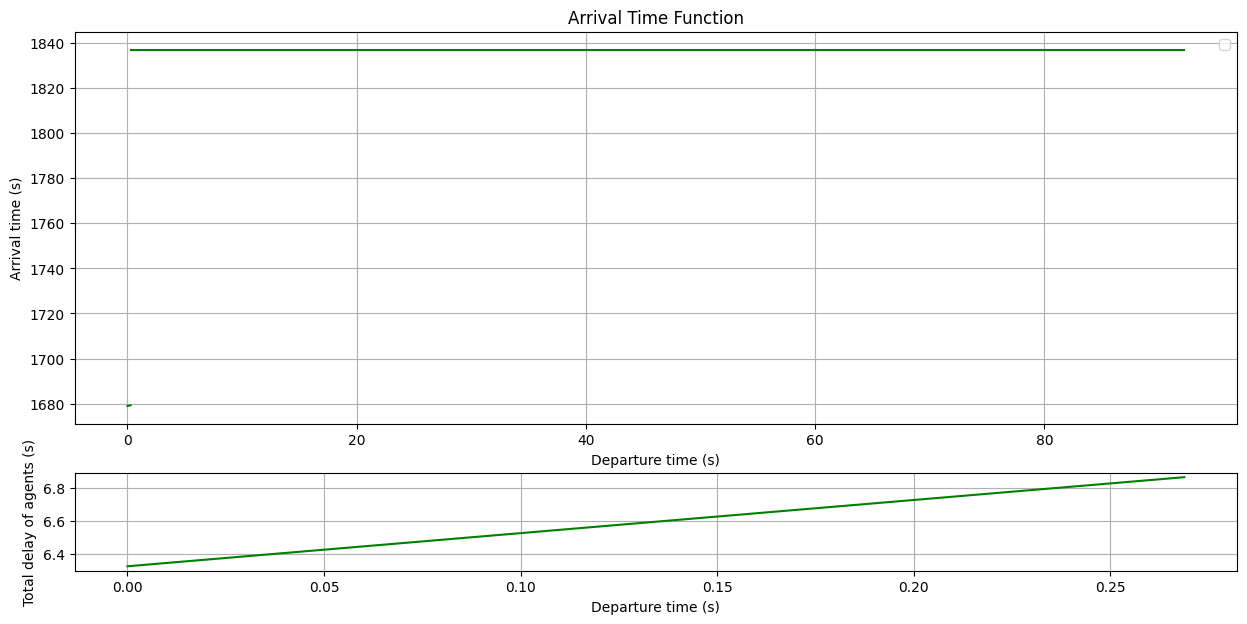

In [11]:
plot_experiments(experiments[::-1])

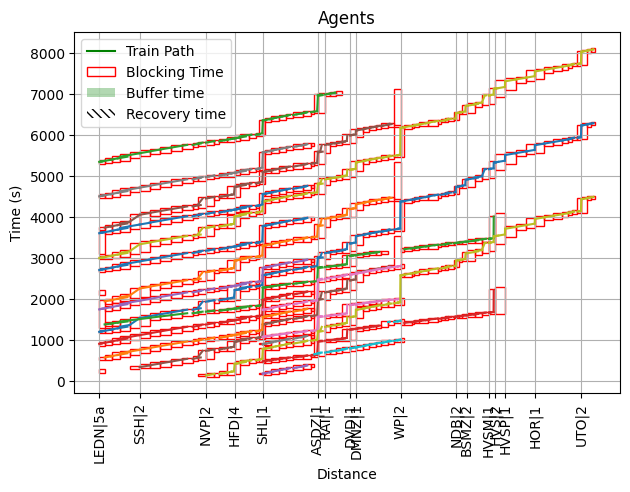

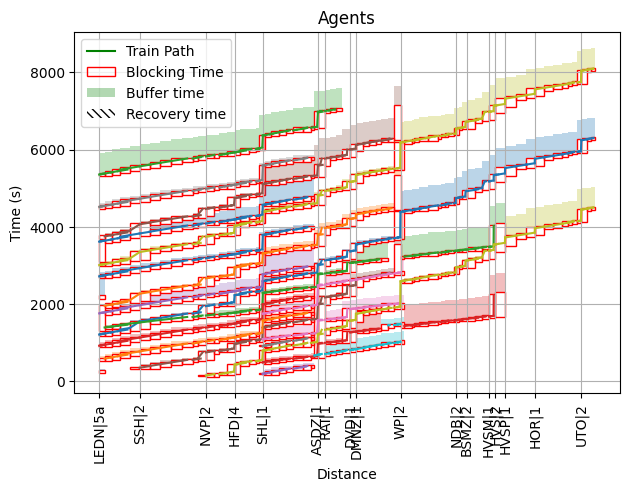

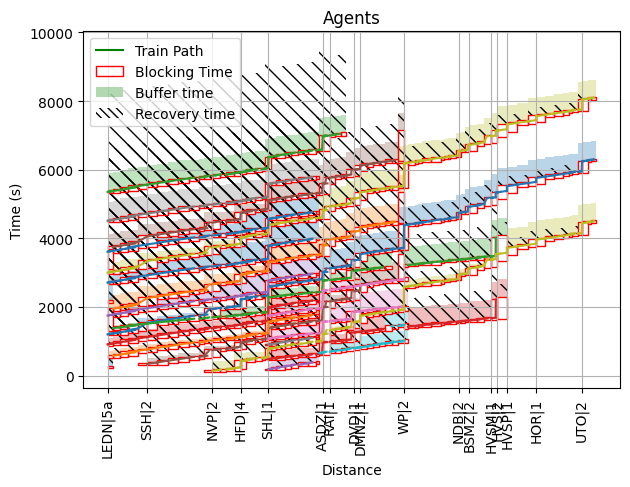

In [12]:
for experiment in experiments:
    experiment.s.plot(2)